# 算法链与管道

In [1]:
# 大多数机器学习应用不仅需要应用单个算法 ,而且还需要将许多不同的处理步骤和机器学习模型链接在一起

# 本章将介绍如何使用pipeline类来简化构建变换和模型链的过程
# 将重点介绍如何键Pipeline 和GridSearchCV结合起来 ,从而同时搜索所有处理步骤中的参数

In [2]:
# 举一个例子来说明模型链的重要性
# 可以通过使用MinMaxScaler 进行预处理来提高SVM在cancer数据集上的性能
# 下面代码实现了划分数据 ,计算最小值和最大值 ,缩放数据与训练SVM

In [3]:
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# 加载并划分数据
cancer = load_breast_cancer()
X_train , X_test , y_train , y_test = train_test_split(cancer.data , cancer.target , random_state = 0)

# 计算训练数据的最小值和最大值
scaler = MinMaxScaler().fit(X_train)

# 对训练数据进行缩放
X_train_scaled = scaler.transform(X_train)

svm = SVC()
# 在缩放后的训练数据上学习SVM
svm.fit(X_train_scaled ,y_train)

# 对测试数据进行缩放 ,并计算缩放后的数据的分数
X_test_scaled = scaler.transform(X_test)
print('Test score:{:.2f}'.format(svm.score(X_test_scaled , y_test)))

Test score:0.97


## 用预处理进行参数选择

In [4]:
# 希望利用GridSearchCV 找到更好的SVC参数

from sklearn.model_selection import GridSearchCV
# 只是为了便于说明 ,不要再实践中使用这些代码

param_grid = {'C':[0.001 , 0.01 , 0.1 , 1 , 10 , 100] , 'gamma':[0.001 , 0.01 , 0.1 , 1 , 10 , 100]}
grid = GridSearchCV(SVC() , param_grid = param_grid ,cv = 5)
grid.fit(X_train_scaled , y_train)
print('Best cross-validation accuracy:{:.2f}'.format(grid.best_score_))
print('Best set score:{:.2f}'.format(grid.score(X_test_scaled , y_test)))
print('Best parameters:',grid.best_params_)

Best cross-validation accuracy:0.98
Best set score:0.97
Best parameters: {'C': 1, 'gamma': 1}


In [5]:
# 这里我们利用缩放后的数据SVC参数进行网格搜索
# 但是 ,上面的代码有一个不易察觉的陷阱

# 在缩放数据时 ,使用了训练集中的所有数据来找到训练的方法
# 然后使用缩放后的训练数据来运行带交叉验证的网格搜索
# 对于交叉验证中的每次划分 ,原始训练集的一部分被划分为训练部分 , 另一部分被划分为测试部分
# 测试部分用于度量在训练部分上所训练的模型在新数据上的表现
# 但是 ,在缩放数据时已经使用过测试部分中所包含的信息

# 请记住 ,交叉验证每次划分的测试部分都是训练集大的一部分 ,使用整个训练集的信息来找到数据的正确缩放

In [6]:
# 对于模型来说 ,这些数据与新数据看起来截然不同
# 如果我们观察新数据(比如测试集中的数据) ,那么这些数据并没有用于对训练数据进行缩放
# 其最大值和最小值也可能与训练数据不同

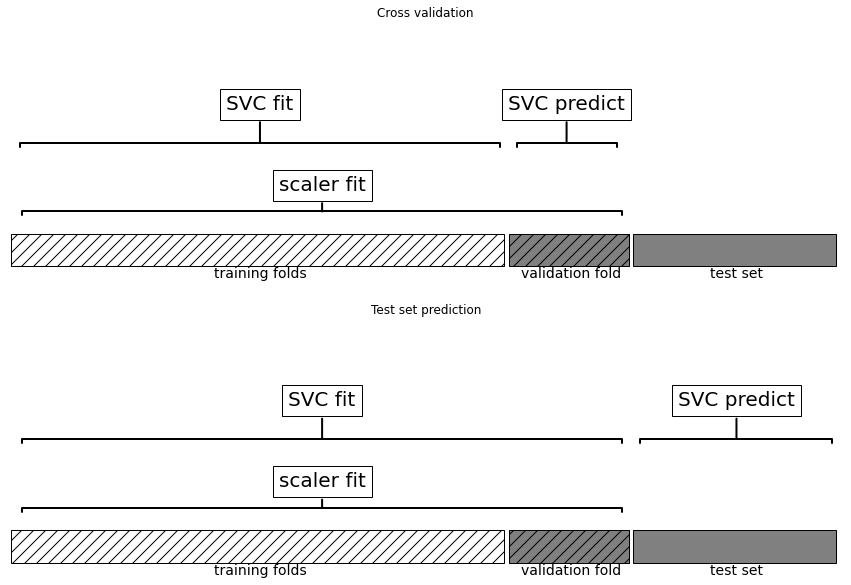

In [7]:
# 交叉验证与最终评估这两个过程中数据处理的不同之处
import mglearn
mglearn.plots.plot_improper_processing()

In [8]:
# 因此 ,对于建模过程 ,交叉验证中的划分无法正确地反映新数据的特征
# 我们已经将这部分数据的信息泄露(leak)给建模过程
# 这将导致在交叉验证过程中得到过于乐观的结果 ,并可能会导致选择次优的参数

In [9]:
# 为了解决这个问题 ,在交叉验证的过程中 ,应该在进行任何预处理之前完成数据集的划分
# 任何从数据集中提取信息的处理过程都应该仅应用于数据集的训练部分
# 因此 ,任何交叉验证都应该位于处理过程的'最外层循环'

In [10]:
# 在scikit-learn中 ,想要使用cross_val_score 函数和 GridSearchCV 函数实现这一点
# 可以使用Pipeline类
# Pipeline类可以将多个处理步骤合并(glue)为单个scikit-learn 估计器
# Pipeline类本身具有fit ,predict 和score方法 ,其行为于scikit-learn中的其他模型相同
# Pipeline类最常见的用例是将预处理步骤(比如数据缩放)与另一个监督模型(比如分类器)链接在一起

## 构建管道

In [11]:
# 使用Pipeline类来表示在使用MinMaxScaler缩放数据之后在训练一个SVM的工作流程(暂时不用网格搜索)

# 首先 ,构建一个由步骤列表组成的管道对象
# 每个步骤都是一个元组 ,其中包含一个名称(你选定的任意字符串)和一个估计器的实例

from sklearn.pipeline import Pipeline
pipe = Pipeline([('Scaler' , MinMaxScaler()) , ('svm' , SVC())])

In [12]:
# 这里创建了两个步骤 : 第一个叫做'scaler' ,是MinMaxScaler的实例
# 第二个叫做'svm' , 是SVC的实例

In [13]:
# 现在可以向任何其他scikit-learn估计器一样来拟合这个管道

pipe.fit(X_train , y_train)

Pipeline(steps=[('Scaler', MinMaxScaler()), ('svm', SVC())])

In [14]:
# 这里pipe.fit 首先对第一个步骤(缩放器)调用fit ,然后使用该缩放器对训练数据进行变换
# 最后用缩放后的数据来拟合SVM
# 想要在测试数据上进行评估 ,只需调用pipe.score

In [15]:
print('Test score:{:.2f}'.format(pipe.score(X_test , y_test)))

Test score:0.97


In [16]:
# 如果对管道调用score方法 , 则首先使用缩放器对测试数据进行变换
# 然后利用缩放后的测试数据对SVM调用score方法

# 这个结果是和开头的代码得到的结果(手动进行数据变换)是相同的

# 利用管道 ,我们减少了'预处理 + 分类'过程所需要的代码量
# 但是 ,使用管道的主要优点在于 ,现在可以在cross_val_score 或 GridSearchCV中使用这个估计器

## 在网格搜索中使用管道

In [17]:
# 在网格搜索中使用管道的工作原理与使用任何其他估计器都相同

# 我们定义与一个需要搜索的参数网格 ,并利用管道和参数网格构建一个GridSearchCV
# 不过在指定参数网络时存在一处细微的变化
# 我们需要为每个参数指定他在管道中所属的步骤
# 要调节的两个参数 C 和 gamma 都是SVC的参数 ,属于第二个步骤

# 我们给这个步骤的名称是'svm'
# 为管道定义参数网格的语法是为每个参数指定步骤名称 ,后面加上__(双下划线) ,然后是参数名称
# 因此 ,想要搜索SVC的 C 参数 ,必须使用'svm__C'作为参数网格字典的键 ,对gamma参数也是同理

In [18]:
param_grid = {'svm__C':[0.001,0.01,0.1,1,10,100],
              'svm__gamma':[0.001,0.01,0.1,1,10,100]}

In [19]:
# 有了这个参数网格 ,可以像平常一样使用GridSearchCV

grid = GridSearchCV(pipe , param_grid = param_grid ,cv = 5)
grid.fit(X_train , y_train)
print('Best cross-validation accuracy:{:.2f}'.format(grid.best_score_))
print('Test set score:{:.2f}'.format(grid.score(X_test ,y_test)))
print('Best parameters:{}'.format(grid.best_params_))

Best cross-validation accuracy:0.98
Test set score:0.97
Best parameters:{'svm__C': 1, 'svm__gamma': 1}


In [20]:
# 与前面所做的网格搜索不同 ,现在对于交叉验证的每次划分来说
# 仅使用训练部分对MinMaxScaler 进行拟合 ,测试部分的信息没有泄露到参数搜索中

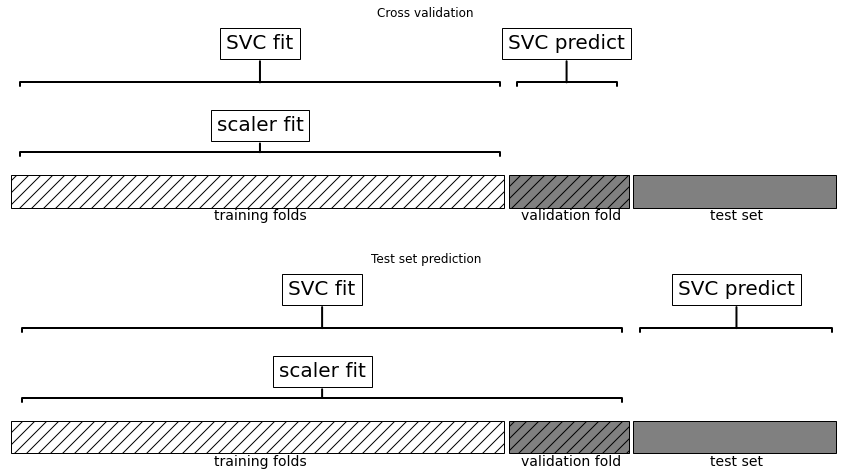

In [21]:
mglearn.plots.plot_proper_processing()

In [22]:
# 在交叉验证中 ,信息泄露的影响大小取决于预处理步骤的性质
# 使用测试部分来估计数据的范围 ,通常不会产生可怕的影响 ,但在特征提取和特征选择中使用测试部分
# 则会导致结果的显著差异

##### 举例说明信息泄露

In [23]:
# 考虑一个假象的回归任务 ,包含从高斯分布中独立采样的100个样本和10000个特征
# 还从高斯分布中对相应进行采样

import numpy as np

rnd = np.random.RandomState(seed = 0)
X = rnd.normal(size = (100 ,10000))
y = rnd.normal(size = (100 ,))

# 考虑到我们创建数据集的方式 ,数据X 与 目标y之间没有任务关系(它们是独立的)
# 所以应该不可能从这个数据中学到任何内容

# 首先利用SelectPercentile特征选择从10000个特征中选择信息量最大的特征 ,然后使用交叉验证对Ridge回归进行评估

from sklearn.feature_selection import SelectPercentile , f_regression

select = SelectPercentile(score_func = f_regression , percentile = 5).fit(X , y)
X_selected = select.transform(X)
print('X_selected.shape:{}'.format(X_selected.shape))

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
print('Cross-validation accuracy(cv only on ridge) :{:.2f}'.format(np.mean(cross_val_score(Ridge() , 
                                                                                           X_selected , y , cv =5))))

# 交叉验证计算得到的平均R^2为0.91 ,表示这是一个非常好的模型
# 这显然是不对的 ,因为我们的数据是完全随机的
# 这里的特征选择从10000个随机特征中(碰巧)选出了与目标相关性非常好的一些特征
# 由于在交叉验证之外对特征选择进行拟合 ,所以它能够找到在训练部分和测试部分都相关的特征
# 从测试部分泄露出去的信息包含的信息量非常大 ,导致得到非常不切实际的结果
# 我们将这个结果与正确的交叉验证(使用管道)进行对比

pipe = Pipeline([('select' ,SelectPercentile(score_func = f_regression , percentile = 5)) , ('ridge' , Ridge())])
print('Cross-validation accuracy (pipeline):{:.2f}'.format(np.mean(cross_val_score(pipe , X , y , cv = 5))))

# 这一次得到了负的R^2分数 ,表示模型很差
# 利用管道 ,特征选择现在位于交叉验证循环内部
# 也就是说 ,仅使用数据的训练部分来选择特征 ,而不使用测试部分
# 特征选择找到的特征在训练集中与目标相关 ,但由于数据是完全随机的 ,这些特征在测试集中并不与目标相关

# 在这个例子中 ,修正特征选择中的数据泄露问题 ,结论也由'模型表现很好' 变为 '模型根本没有效果'

X_selected.shape:(100, 500)
Cross-validation accuracy(cv only on ridge) :0.91
Cross-validation accuracy (pipeline):-0.25


## 通用的管道接口

In [24]:
# pipeline 类不但可用于预处理和分类 ,实际上还可以将任意数量的估计器连接在一起

# 例如 ,你可以构建一个包含特征提取 ,特征选择 ,缩放和分类的管道 ,总共有4个步骤
# 同样 ,最后一步可以用回归或聚类代替分类

In [25]:
# 对于管道中估计器的唯一要求就是 ,除了最后一步之外的所有步骤都需要具有transform方法
# 这样它们可以生成新的数据表示 ,以供下一个步骤使用

In [26]:
# 在调用pipeline.fit的过程中 ,管道内部依次对每个步骤调用fit 和transform ,其输入是前一个步骤中transform方法的输出
# 对于管道中的最后一步 ,则仅调用fit

In [27]:
# 忽略某些细枝末节 ,其实现方法如下所示
# 请记住 ,pipeline.steps 是由元组组成的列表 ,所以pipeline.steps[0][1]是第一个估计器 ,pipeline.steps[1][1]是第二个估计器 ,以此类推

In [28]:
def fit(self , X , y):
    X_transformed = X
    for name , estimator in self.steps[:-1]:
        # 遍历除最后一步之外的所有步骤
        # 对数据进行拟合和变换
        X_transformed = estimator.fit_transform(X_transformed , y)
    # 对最后一步进行拟合
    self.steps[-1][1].fit(X_transformed , y)
    return self

In [29]:
# 使用Pipeline进行预测时 ,同样利用除最后一步之外的所有步骤对数据进行变换(transform) ,然后对最后一步调用predict

def predict(self , X):
    X_transformed = X 
    for step in self.steps[:-1]:
        # 遍历除最后一步之外的所有步骤
        # 对数据进行变换
        X_transformed = step[1].transform(X_transformed)
    # 利用最后一步进行预测
    return self.steps[-1][1].predict(X_transformed)

In [30]:
# 其中包含两个变换器(transformer) T1 和 T2 , 还有一个分类器(叫做Classifier)

In [31]:
# 管道的最后一步不需要具有predict函数
# 比如说 ,可以创建一个只包含一个缩放器和一个PCA的管道
# 由于最后一步(PCA)具有transform方法 ,所以可以对管道调用transform ,以得到将PCA.transform应用于前一个步骤处理过的数据后得到的输出
# 管道的最后一步只需要具有fit方法

### 用make_pipeline方便地创造管道

In [32]:
# 利用上述语法创建管道有时有点麻烦 ,通常不需要为每一个步骤提供用户指定的名称
# 有一个很方便的函数make_pipeline ,可以为我们创建管道并根据每个步骤所属的类为其自动命名

In [33]:
from sklearn.pipeline import make_pipeline

# 标准语法
pipe_long = Pipeline([('scaler' , MinMaxScaler()) , ('svm' , SVC(C = 100))])
# 缩写语法
pipe_short = make_pipeline(MinMaxScaler() , SVC(C = 100))

In [34]:
# 管道对象pipe_long 和pipe_short的作用完全相同 ,但pipe_short的步骤是自动命名的
# 可以通过查看steps属性来查看步骤的名称

In [35]:
print('Pipeline steps:\n{}'.format(pipe_short.steps))

Pipeline steps:
[('minmaxscaler', MinMaxScaler()), ('svc', SVC(C=100))]


In [36]:
# 这两个步骤被命名为 minmaxscaler 和 svc
# 一般来说 ,步骤名称只是类名称的小写版本
# 如果多个步骤属于同一个类 ,则会附加一个数字

In [37]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pipe = make_pipeline(StandardScaler() , PCA(n_components = 2) ,StandardScaler())
print('Pipeline steps:\n{}'.format(pipe.steps))

Pipeline steps:
[('standardscaler-1', StandardScaler()), ('pca', PCA(n_components=2)), ('standardscaler-2', StandardScaler())]


In [38]:
# 第一个StandardScaler 步骤被命名为 standardscaler-1 , 而第二个被命名为 standardscaler-2
# 但在这种情况下 ,使用具有明确名称的Pipeline构建可能更好 ,以便为每个步骤提供更具意义的名称

### 访问步骤属性

In [39]:
# 通常来说 ,希望检查管道中某一步骤的属性
# 比如线性模型的系数或PCA提取的成分
# 要想访问管道中的步骤 ,最简单的方法是通过named_steps属性 ,它是一个字典 ,将步骤名称映射为估计器

In [40]:
# 用前面定义的管道对cancer数据集进行拟合
pipe.fit(cancer.data)
# 从'pca'步骤中提取前两个主成分
components = pipe.named_steps['pca'].components_
print('components.shape:{}'.format(components.shape))

components.shape:(2, 30)


### 访问网格搜索管道中的属性

In [41]:
# 使用管道的主要原因之一就是进行网格搜索
# 一个常见的任务是在网格搜索内访问网格搜索管道的某些步骤

# 对cancer数据集上的LogisticRegression分类器进行网格搜索 ,在将数据传入LogisticRegression分类器之前
# 先用Pipeline 和 StandardScaler对数据进行缩放

# 首先 ,用make_pipeline函数创建一个管道

In [42]:
from sklearn.linear_model import LogisticRegression

pipe = make_pipeline(StandardScaler() , LogisticRegression(max_iter = 3000))

In [43]:
# 接下来 ,创建一个参数网格 
# LogisticRegression 需要调节的正则化参数是参数C
# 对这个参数使用对数网络 , 在0.01和 100之间进行搜索
# 由于使用了make_pipeline函数 ,所以管道中LogisticRegression 步骤的名称是小写的类名称logisticregression
# 因此 ,为了调节参数C ,必须指定logisticregression__C的参数网格

In [44]:
param_grid = {'logisticregression__C':[0.01 ,0.1 , 1 , 10 , 100]}

In [45]:
# 像往常一样 ,将cancer数据集划分为训练集和测试集 , 并对网格搜索进行拟合

X_train , X_test , y_train , y_test = train_test_split(cancer.data ,cancer.target ,random_state = 4)
grid = GridSearchCV(pipe , param_grid , cv = 5)
grid.fit(X_train , y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=3000))]),
             param_grid={'logisticregression__C': [0.01, 0.1, 1, 10, 100]})

In [46]:
# GridSearchCV 找到的最佳模型 (在所有训练数据上训练得到的模型)保存在grid.best_estimator_

In [47]:
print('Best estimator:\n{}'.format(grid.best_estimator_))

Best estimator:
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(C=1, max_iter=3000))])


In [48]:
# best_estimator_ 是一个管道 ,它包含两个步骤:
# standardscaler 和 logisticregression
# 可以使用管道的named_steps属性来访问 logisticregression 步骤:

In [49]:
print('Logistic regression step:\n{}'.format(grid.best_estimator_.named_steps['logisticregression']))

Logistic regression step:
LogisticRegression(C=1, max_iter=3000)


In [50]:
# 现在得到了训练过的LogisticRegression实例 
# 访问与每个输入特征相关的系数(权重)

In [51]:
print('LogisticRegression coefficients:\n{}'.format(grid.best_estimator_.named_steps['logisticregression'].coef_))
# 这个系数列表可能有点长 ,但它通常有助于理解你的模型

LogisticRegression coefficients:
[[-0.43570655 -0.34266946 -0.40809443 -0.5344574  -0.14971847  0.61034122
  -0.72634347 -0.78538827  0.03886087  0.27497198 -1.29780109  0.04926005
  -0.67336941 -0.93447426 -0.13939555  0.45032641 -0.13009864 -0.10144273
   0.43432027  0.71596578 -1.09068862 -1.09463976 -0.85183755 -1.06406198
  -0.74316099  0.07252425 -0.82323903 -0.65321239 -0.64379499 -0.42026013]]


## 网格搜索预处理步骤与模型参数

In [52]:
# 可以利用管道将机器学习工作流程中的所有处理步骤封装成一个scikit-learn估计器

# 这么做的另一个好处在于 ,现在可以使用监督任务(比如回归或分类)的输出来调节预处理参数

# 管道包含3个步骤 : 缩放数据 , 计算多项式特征 ,岭回归

In [53]:
from sklearn.datasets import load_boston
boston = load_boston()

X_train , X_test , y_train , y_test = train_test_split(boston.data ,boston.target , random_state = 0)

from sklearn.preprocessing import PolynomialFeatures
pipe = make_pipeline(StandardScaler() , PolynomialFeatures() ,Ridge())

In [54]:
# 怎么知道选择几次多项式 ,或者是否选择多项式或者交互项呢?
# 理想情况下 ,我们希望根据分类结果来选择degree参数

# 可以利用管道搜索degree参数以及Ridge 的alpha参数
# 为了做到这一点 , 要定义一个包含这两个参数的param_grid ,并用步骤名称作为前缀

In [55]:
param_grid = {'polynomialfeatures__degree': [1,2,3] , 'ridge__alpha' : [0.001,0.01,0.1,1,10,100]}

In [56]:
grid = GridSearchCV(pipe , param_grid = param_grid , cv = 5 , n_jobs = -1)
grid.fit(X_train , y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('ridge', Ridge())]),
             n_jobs=-1,
             param_grid={'polynomialfeatures__degree': [1, 2, 3],
                         'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]})

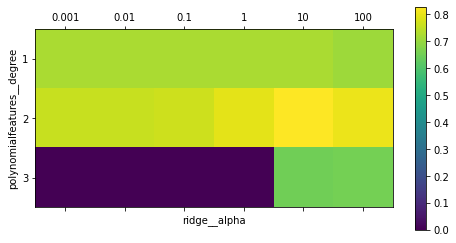

In [57]:
import matplotlib.pyplot as plt

plt.matshow(grid.cv_results_['mean_test_score'].reshape(3,-1) , vmin = 0 , cmap = 'viridis')
plt.xlabel('ridge__alpha')
plt.ylabel('polynomialfeatures__degree')
plt.xticks(range(len(param_grid['ridge__alpha'])),param_grid['ridge__alpha'])
plt.yticks(range(len(param_grid['polynomialfeatures__degree'])) ,param_grid['polynomialfeatures__degree'])

plt.colorbar()
plt.show()

In [58]:
# 从交叉验证的结果中可以看出 ,使用二次多项式很有用 ,但三次多项式的效果比一次或二次都要差很多
# 从找到的最佳参数中也可以看出这一点:

In [59]:
print('Best parameters:{}'.format(grid.best_params_))

Best parameters:{'polynomialfeatures__degree': 2, 'ridge__alpha': 10}


In [60]:
# 这个最佳参数对应的分数应该如下:

print('Test-set score:{:.2f}'.format(grid.score(X_test , y_test)))

Test-set score:0.77


In [61]:
# 为了对比 ,运行一个没有多项式特征的网格搜索

param_grid = {'ridge__alpha':[0.001 , 0.01 , 0.1 , 1 , 10 ,100]}
pipe = make_pipeline(StandardScaler() , Ridge())
grid = GridSearchCV(pipe , param_grid , cv = 5)
grid.fit(X_train , y_train)
print('Score without poly feature:{:.2f}'.format(grid.score(X_test , y_test)))

Score without poly feature:0.63


In [62]:
# 不适用多项式特征得到了明显更差的结果

In [63]:
# 同时搜索预处理参数于模型参数是一个非常强大的策略

# 但是要记住 ,GridSearchCV 会尝试指定参数的所有可能组合
# 因此 ,向网格中添加更多参数 ,需要构建的模型数量将呈指数增长

## 网格搜索选择使用哪个模型

In [ ]:
# 甚至可以进一步将GridSearchCV 和 Pipeline结合起来
# 还可以搜索管道中正在执行的实际步骤(比如用StandardScaler 还是用 MinMaxScaler)

# 这样会导致更大的搜索空间 ,应该予以仔细考虑
# 尝试所有可能的解决饭感 ,通常并不是一种可行的机器学习策略

# 但下边是一个例子 :在iris数据集上比较RandomForestClassifier 和SVC
# SVC 可能需要对数据进行缩放 ,所以还需要搜索时使用StandardScaler 还是不使用预处理

# RandomForestClassifier 不需要预处理 

# 先定义管道
# 显式地对步骤命名
# 需要两个步骤 ,一个用于预处理 ,然后是一个分类器
# 可以用SVC 和 StandardScaler 来将其实例化

In [72]:
pipe  = Pipeline([('preprocessing',StandardScaler()) , ('classifier' ,SVC())])

In [73]:
# 可以定义需要搜索的parameter_grid
# 我们希望classifier 是 RandomForestClassifier 或 SVC

# 由于这两种分类器需要调节不同的参数 ,并且需要不同的预处理
# 为了将一个估计器分配给一个步骤 ,我们使用步骤名称作为参数名称
# 如果我们想跳过管道中的某个步骤
# (例如 ,RandomForest不需要预处理) ,则可以将该步骤设置为None

In [74]:
from sklearn.ensemble import RandomForestClassifier

param_grid = [{'classifier':[SVC()] , 'preprocessing':[StandardScaler() , None],
              'classifier__gamma' : [0.001,0.01,0.1,1,10,100],
              'classifier__C' : [0.001,0.01,0.1,1,10,100]},
             {'classifier':[RandomForestClassifier(n_estimators = 100)],
             'preprocessing':[None] , 'classifier__max_features':[1,2,3]}]

In [75]:
X_train , X_test , y_train , y_test = train_test_split(cancer.data ,cancer.target ,random_state = 0)

grid = GridSearchCV(pipe , param_grid , cv = 5)
grid.fit(X_train , y_train)
print('Best params:\n{}\n'.format(grid.best_params_))
print('Best cross-validation score:{:2f}'.format(grid.best_score_))
print('Test-set score:{:.2f}'.format(grid.score(X_test , y_test)))

Best params:
{'classifier': SVC(C=10, gamma=0.01), 'classifier__C': 10, 'classifier__gamma': 0.01, 'preprocessing': StandardScaler()}

Best cross-validation score:0.985882
Test-set score:0.98


In [ ]:
# 网格搜索的结果是SVC 与 StandardScaler预处理 ,在C = 10 和 gamma = 0.01 时给出最佳结果

## 小结与展望

In [ ]:
# Pipelin类 ,这时一种通用工具 ,可以将机器学习工作流程中的多个处理步骤链接在一起 
# 现实世界中的机器学习的应用很少仅涉及模型的单独使用 ,而是需要一系列处理步骤

# 使用管道可以将多个步骤封装为单个Python对象 ,这个对象具有我们熟悉的scikit-learn接口fit , predict 和 transform
# 特别是使用交叉验证进行模型评估与使用网格搜索进行参数选择时
# 使用Pipeline类来包括所有处理步骤对正确的评估至关重要

# 利用Pipeline可以让代码更加简洁 ,并减少不用pipeline类构建处理链时可能会犯的错误
# (比如忘记将所有变换器应用于测试集 ,或者应用顺序错误)的可能性
# 选择特征提起 ,预处理和模型的正确组合 ,这在某种程度上时一门艺术 ,通常需要一些试错
# 但是有了管道 ,这种'尝试'多个不同的处理步骤是非常简单的

# 在进行试验时 ,是小心不要将处理过程复杂化 ,并且一定要评估一下模型中的每个组件是否必要